In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from utils.utils import MyDataset, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy
from torch.autograd import Variable 

In [2]:
train_dataset = MyDataset(root='../../data/complete_random/hetero_1/Sub20x20_full_grid.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [3]:
latent_dims = 256
capacity = latent_dims//2 
input_size = 20
epochs = 100
sigmoid = False
instance = "hetero_1"
lr1 = 1e-3
params = {
    "input_size": input_size,
    "latent_dims": latent_dims,
    "capacity": capacity,
    "epochs": epochs,
    "sigmoid": sigmoid,
    "instance": instance,
    "lr1": lr1,
}
net = FireAutoencoder(params)
net.load_state_dict(torch.load(f'../weights/hetero_1/AE/sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}_sigmoid={sigmoid}_T1=100_T2=100_lr1={lr1}_lr2=0.0001_lr3=0.0001_normalize=False_weight_decay=0.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
net.eval()

FireAutoencoder(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=6400, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=6400, bias=True)
  (conv1_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (criterion): MSELoss()
)

In [5]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [6]:
all_images, all_r = next(iter(full_loader))

In [ ]:
embeddings = net.encode(all_images)

In [ ]:
with torch.no_grad():
    rewards = net.predict_reward(embeddings)

In [ ]:
rewards

In [10]:
rewards = train_dataset.reconstruct(rewards)

In [11]:
rewards = [i.item() for i in rewards]

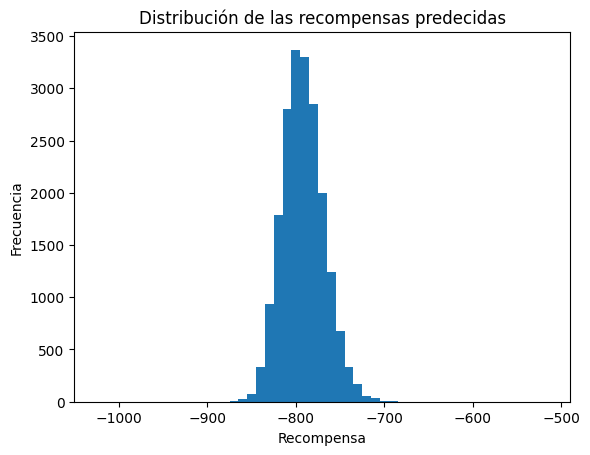

In [12]:
bins = np.arange(-1020, -500, 10)
plt.hist(rewards, bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.savefig(f"linear_regresion/AE_Reward/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [13]:
minimum = Variable(torch.zeros(1, latent_dims), requires_grad=True) 

In [14]:
optimizer = torch.optim.Adam([minimum], lr = 0.001)

In [16]:
for i in range(5000):
    my_single_scalar = -net.predict_reward(minimum)
    optimizer.zero_grad()
    my_single_scalar.backward()
    optimizer.step()

In [17]:
net.float()

FireAutoencoder_reward(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6400, out_features=256, bias=True)
  (bn_3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=256, out_features=6400, bias=True)
  (bn_1_2): BatchNorm1d(6400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (conv2_2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2

In [18]:
solution = net.decode(minimum.float())

In [19]:
solution

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0958e-01, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
   

In [20]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<=0.5] = 0
else:
    solution[solution>0] = 1

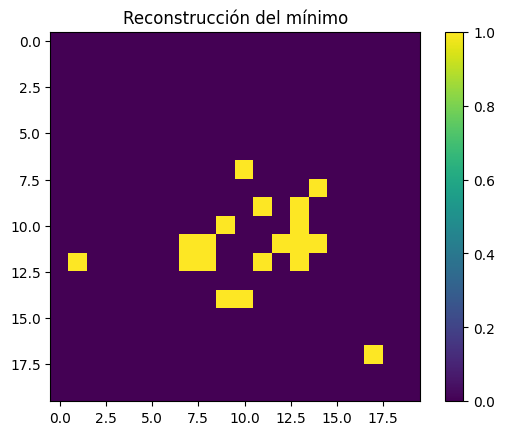

In [21]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        plt.savefig(f"linear_regresion/AE_Reward/minimum_decoding_{latent_dims}_{epochs}_sigmoid={sigmoid}.png")
        plt.colorbar()
        plt.show()

In [55]:
with torch.no_grad():
    print(repr(solution[0][0].numpy()))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.